In [23]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")



In [5]:
data = pd.read_csv("/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv")

In [6]:
data.columns

Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3994', 'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999',
       'basemap_id', 'maj_landcover_code', 'status', 'structure_code'],
      dtype='object', length=4005)

In [7]:
# drop basemap_id 

data = data.drop(columns = 'basemap_id')

In [8]:
data.columns

Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3993', 'X_3994', 'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999',
       'maj_landcover_code', 'status', 'structure_code'],
      dtype='object', length=4004)

## Full Dataset Approach

In [9]:
# X = data.drop("status", axis=1)
# y = data["status"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


## Balanced Approach

In [10]:
# Balanced dataset -- 25% non-compliant

compliant = data[data.status == 0]
non_compliant = data[data.status == 1]

# Making non-compliant 25% of the dataset
n_majority_desired = len(non_compliant) * 3

# Downsample number of compliant rows
compliant_down = compliant.sample(n = n_majority_desired, random_state=42)

# reassemble and shuffle
balanced = (
    pd.concat([non_compliant, compliant_down])
    .sample(frac = 1, random_state = 42)
    .reset_index(drop = True)
)

balanced.status.value_counts(normalize=True)


status
0    0.75
1    0.25
Name: proportion, dtype: float64

In [11]:
# variable for this downsampling approach is `balanced`

X_balanced = balanced.drop("status", axis = 1)
y_balanced = balanced["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify = y_balanced
)

## The Model

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.749003984063745


In [13]:
param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "class_weight": [None, "balanced", "balanced_subsample"],
}

param_dist.update(
    {
        "min_samples_leaf": [1, 5, 10, 20],
        "max_features": ["sqrt", "log2", 0.2, 0.5],
    }
)

rf = RandomForestClassifier(
    random_state = 42,
    n_jobs = -1
)

rand_search = RandomizedSearchCV(
    rf,
    param_distributions = param_dist,
    n_iter = 20,
    cv = 3,
    scoring = "precision",
    refit = True,
    n_jobs = 1,
    verbose = 1,
)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

y_scores = best_rf.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
## TESTING PRECISION
# greatest precision achievable is 0.5, default


# 6) Quick diagnostic of your score distribution
# print("Probability range:", y_scores.min(), "to", y_scores.max())
# print("Positives at 0.5 cutoff:", (y_scores >= 0.5).sum())

# # 7) Try a few fixed thresholds
# for thresh in [0.5, 0.6, 0.7, 0.8]:
#     preds = (y_scores >= thresh).astype(int)
#     print(f"\nThreshold {thresh:.1f} → Positives = {preds.sum()}")
#     print(" Precision:", precision_score(y_test, preds))
#     print(" Recall:   ", recall_score(y_test, preds))

# # 8) Precision–Recall curve based threshold search
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# precisions = precisions[:-1]  # align lengths with thresholds

# # What’s the best precision you can actually hit?
# best_possible_precision = precisions.max()
# print("\nBest achievable precision:", best_possible_precision)

# # Now find the first threshold that reaches ≥0.6, if any
# target = 0.6
# valid = np.where(precisions >= target)[0]

# if valid.size:
#     best_idx = valid[0]
#     best_thresh = thresholds[best_idx]
#     print(f"Threshold for ≥{target:.2f} precision:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print(" Precision:", precision_score(y_test, y_pred_opt))
#     print(" Recall:   ", recall_score(y_test, y_pred_opt))
# else:
#     print(
#         f"No threshold yields ≥{target:.2f} precision. "
#         f"Falling back to best achievable precision of "
#         f"{best_possible_precision:.3f}."
#     )
#     # you could pick the threshold for that best precision:
#     best_idx = np.argmax(precisions)
#     best_thresh = thresholds[best_idx]
#     print("  Using threshold:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print("  Precision:", precision_score(y_test, y_pred_opt))
#     print("  Recall:   ", recall_score(y_test, y_pred_opt))

Accuracy: 0.7470119521912351
Precision: 0.4
Recall: 0.015873015873015872


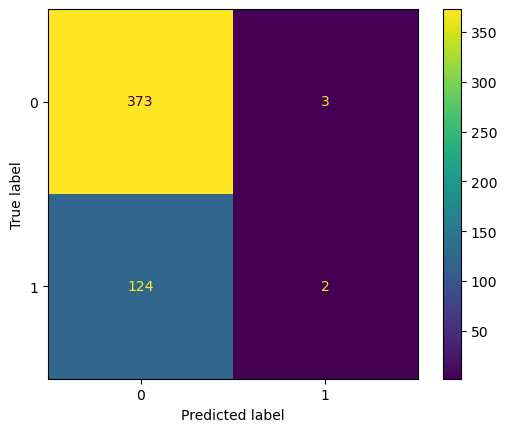

In [15]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [16]:
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

feature_importances.head()


maj_landcover_code    0.003315
X_603                 0.002145
X_3756                0.001530
X_1041                0.001465
X_2391                0.001338
dtype: float64

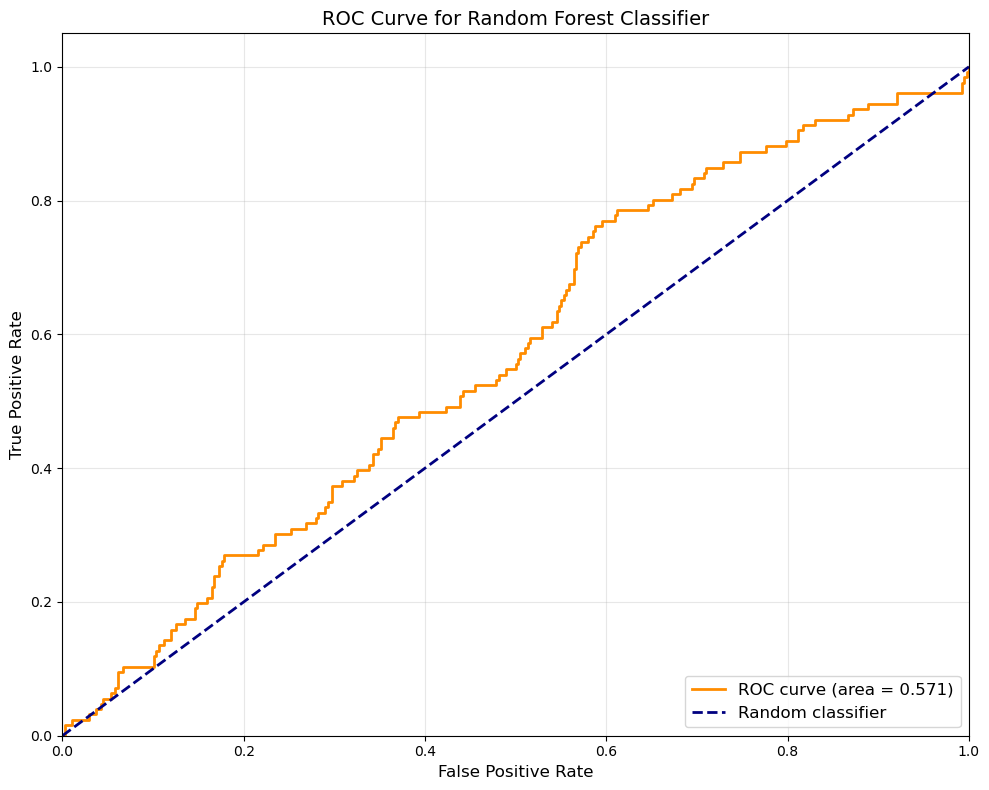

ROC AUC Score: 0.5707


In [27]:
# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")
